# Prepare data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# change this to the path in google drive where the files are located
%cd /content/drive/MyDrive/TDDE09 Project/Code

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1NeFHUkpRXe8AvGwOOij0YjGFr79_V8SQ/TDDE09 Project/Code


In [ ]:
# projectivize trees
!python projectivize.py < en_ewt-ud-train.conllu > en_ewt-ud-train-projectivized.conllu
!python projectivize.py < en_ewt-ud-dev.conllu > en_ewt-ud-dev-projectivized.conllu
!python projectivize.py < en_ewt-ud-test.conllu > en_ewt-ud-test-projectivized.conllu

In [ ]:
class Dataset():

    ROOT = ('<root>', '<root>', 0)

    def __init__(self, filename):
        self.filename = filename

    def __iter__(self):
        with open(self.filename, 'rt', encoding='utf-8') as lines:
            tmp = [Dataset.ROOT]
            for line in lines:
                line = line.rstrip()
                if line:
                    columns = line.split('\t')
                    tmp.append((columns[1], columns[3], int(columns[6])))
                else:
                    yield tmp
                    tmp = [Dataset.ROOT]

In [ ]:
# read the data
train_data = Dataset('en_ewt-ud-train-projectivized.conllu')
dev_data = Dataset('en_ewt-ud-dev-projectivized.conllu')
test_data = Dataset('en_ewt-ud-test-projectivized.conllu')

# Baseline system

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
PAD = '<pad>'
UNK = '<unk>'

def make_vocabs(gold_data):
    word_dict, tag_dict = {PAD: 0, UNK: 1}, {PAD: 0}
    for sentence in gold_data:
        for word, tag, head in sentence:
            if word not in word_dict:
                word_dict[word] = len(word_dict)
            if tag not in tag_dict:
                tag_dict[tag] = len(tag_dict)
    return word_dict, tag_dict

def exclude_root(vocab):
    new_vocab = {}
    for key, value in vocab.items():
        if key != "<root>":
          new_vocab[key] = len(new_vocab)
    return new_vocab

In [ ]:
class ArcStandardParser():
    
    MOVES = tuple(range(3))
    SH, LA, RA = MOVES

    @staticmethod
    def initial_config(num_words):
        return (0, [], [0]*num_words)

    @staticmethod
    def valid_moves(config):
        valid_moves = []
        if config[0] < len(config[2]):
            valid_moves.append(ArcStandardParser.SH)
        if len(config[1]) >= 3:
            valid_moves.append(ArcStandardParser.LA)
        if len(config[1]) >= 2:
            valid_moves.append(ArcStandardParser.RA)
        return valid_moves

    @staticmethod
    def next_config(config, move):
        new_config = [int(config[0]), list(config[1]), list(config[2])]
        if move == ArcStandardParser.SH:
            new_config[1].append(new_config[0])
            new_config[0] += 1
        elif move == ArcStandardParser.LA:
            dependent = new_config[1].pop(-2)
            new_config[2][dependent] = new_config[1][-1]
        elif move == ArcStandardParser.RA:
            dependent = new_config[1].pop(-1)
            new_config[2][dependent] = new_config[1][-1]
        return tuple(new_config) 

    @staticmethod
    def is_final_config(config):
        return (config[0] == len(config[2]) and len(config[1]) == 1)

In [ ]:
def oracle_moves(gold_heads):
    parser = ArcStandardParser()
    config = parser.initial_config(len(gold_heads))
    
    while not parser.is_final_config(config):
        valid_moves, move = parser.valid_moves(config), None

        if (ArcStandardParser.LA in valid_moves and gold_heads[config[1][-2]] == config[1][-1] and
            config[2].count(config[1][-2]) == gold_heads.count(config[1][-2])):
            move = ArcStandardParser.LA

        elif (ArcStandardParser.RA in valid_moves and gold_heads[config[1][-1]] == config[1][-2] and 
              config[2].count(config[1][-1]) == gold_heads.count(config[1][-1])):
            move = ArcStandardParser.RA

        elif ArcStandardParser.SH in valid_moves:
            move = ArcStandardParser.SH
        
        yield (config, move)
        config = parser.next_config(config, move)

In [ ]:
class FixedWindowModel(nn.Module):

    def __init__(self, embedding_specs, hidden_dim, output_dim):
        self.embedding_specs = embedding_specs
        super(FixedWindowModel, self).__init__()
        self.embeddings = nn.ModuleDict()
        input_dim = 0
        
        for i, spec in enumerate(embedding_specs):
            embedding = nn.Embedding(spec[1], spec[2])
            nn.init.normal_(embedding.weight, mean=0.0, std=10**-2)
            self.embeddings["emb"+str(i)] = embedding
            input_dim += spec[0]*embedding.weight.shape[1]

        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, features, eval=False):
        x = []      
        col_indx = 0
        for layer, spec in enumerate(self.embedding_specs):
            for i in range(spec[0]):
                try:
                    current_col = features[:, col_indx:col_indx+1]
                except:
                    current_col = features[col_indx:col_indx+1]
                col_indx += 1
                embedding = self.embeddings["emb"+str(layer)](current_col)
                x.append(embedding)
        x = torch.cat(x, dim=x[0].dim()-1).squeeze()
        x = F.relu(self.hidden(x))
        x = self.output(x)
        return x if (x.dim() > 1 or eval) else x.unsqueeze(0)

In [ ]:
class FixedWindowTagger():

    def __init__(self, vocab_words, vocab_tags, output_dim, word_dim=50, tag_dim=10, hidden_dim=100):
        self.embedding_specs = [(3, len(vocab_words), word_dim), (1, len(vocab_tags), tag_dim)]
        self.model = FixedWindowModel(self.embedding_specs, hidden_dim, output_dim).to(device)
        self.vocab_words = vocab_words
        self.vocab_tags = vocab_tags

    def featurize(self, words, i, pred_tags):
        previous_tag = self.vocab_tags[PAD] if not pred_tags else pred_tags[-1]
        previous_word = self.vocab_words[PAD] if i == 0 else words[i-1]
        next_word = self.vocab_words[PAD] if i+1 >= len(words) else words[i+1]
        return torch.LongTensor([previous_word, words[i], next_word, previous_tag])

    def predict(self, words):
        word_ids = [self.vocab_words.get(word, self.vocab_words[UNK]) for word in words]
        predicted_tags_ids = []
        for i, word_id in enumerate(word_ids):
            feature = self.featurize(word_ids, i, predicted_tags_ids)
            with torch.no_grad():
                prediction = torch.argmax(self.model.forward(feature.to(device), eval=True))
            predicted_tags_ids.append(prediction)
        predicted_tags = [list(self.vocab_tags.keys())[tag_id] for tag_id in predicted_tags_ids]
        return predicted_tags

    def training_examples(self, gold_data, batch_size=100):
        features, labels = [], []
        for sentence in gold_data:
            word_ids = [self.vocab_words[word] for word, tag, head in sentence]
            tag_ids = [self.vocab_tags[tag] for word, tag, head in sentence]
            for i in range(len(sentence)):
                feature = self.featurize(word_ids, i, tag_ids[:i])
                features.append(feature)
                labels.append(tag_ids[i])
                if len(features) == batch_size:
                    yield torch.stack(features).to(device), torch.LongTensor(labels).to(device)
                    features, labels = [], []
        yield torch.stack(features).to(device), torch.LongTensor(labels).to(device)

In [ ]:
class FixedWindowParser(ArcStandardParser):

    def __init__(self, vocab_words, vocab_tags, word_dim=50, tag_dim=10, hidden_dim=180):
        self.embedding_specs = [(3, len(vocab_words), word_dim), (3, len(vocab_tags), tag_dim)]
        self.model = FixedWindowModel(self.embedding_specs, hidden_dim, len(FixedWindowParser.MOVES)).to(device)
        self.vocab_words = vocab_words
        self.vocab_tags = vocab_tags

    def featurize(self, words, tags, config):
        i, stack = config[0], config[1]
        next_buffer_word = words[i] if len(words) > i else self.vocab_words[PAD]
        top_word_stack = words[stack[-1]] if stack else self.vocab_words[PAD]
        second_top_word_stack = words[stack[-2]] if len(stack) >= 2 else self.vocab_words[PAD]
        next_buffer_tag = tags[i] if len(tags) > i else self.vocab_tags[PAD]
        top_tag_stack = tags[stack[-1]] if stack else self.vocab_tags[PAD]
        second_top_tag_stack = tags[stack[-2]] if len(stack) >= 2 else self.vocab_tags[PAD]
        return torch.LongTensor([next_buffer_word, top_word_stack, second_top_word_stack, 
                                 next_buffer_tag, top_tag_stack, second_top_tag_stack])

    def predict(self, words, tags):
        word_ids = [self.vocab_words.get(word, self.vocab_words[UNK]) for word in words]
        tag_ids = [self.vocab_tags[tag] for tag in tags]
        config = self.initial_config(len(word_ids))
        while not self.is_final_config(config):
            feature = self.featurize(word_ids, tag_ids, config)
            with torch.no_grad():
                predictions = self.model.forward(feature.to(device), eval=True)
            valid_moves = self.valid_moves(config)
            move = valid_moves[torch.argmax(torch.tensor([pred for pred in predictions if (predictions == pred).nonzero(as_tuple=True)[0] in valid_moves])).item()]
            config = self.next_config(config, move)
        return config[2]

    def training_examples(self, gold_data, batch_size=100):
        features, labels = [], []
        for sentence in gold_data:
            word_ids = [self.vocab_words[word] for word, tag, head in sentence]
            tag_ids = [self.vocab_tags[tag] for word, tag, head in sentence]
            gold_heads = [head for word, tag, head in sentence]
            for config, move in oracle_moves(gold_heads):
                feature = self.featurize(word_ids, tag_ids, config)
                features.append(feature)
                labels.append(move)
                if len(features) == batch_size:
                    yield torch.stack(features).to(device), torch.LongTensor(labels).to(device)
                    features, labels = [], []
        yield torch.stack(features).to(device), torch.LongTensor(labels).to(device)

In [ ]:
class TaggerParserPipeline():
  
  def __init__(self, vocab_words, vocab_tags):
      # new vocabs without <root> for the tagger
      vocab_words_no_root = exclude_root(vocab_words)
      vocab_tags_no_root = exclude_root(vocab_tags)
      self.tagger = FixedWindowTagger(vocab_words_no_root, vocab_tags_no_root, len(vocab_tags_no_root))
      self.parser = FixedWindowParser(vocab_words, vocab_tags)

  def predict(self, words):
      """Make predictions for tags and heads."""
      tag_preds = self.tagger.predict(words)
      head_preds = self.parser.predict(['<root>']+words, ['<root>']+tag_preds)
      return tag_preds, head_preds
  
  def train_fixed_window(self, train_data, n_epochs=2, batch_size=100, lr=1e-2, component=None): 
      """Run training for a given component of the pipeline (either tagger or parser)."""   
      optimizer = optim.Adam(component.model.parameters(), lr=lr)
      info = {'epoch': 0, 'training loss': 0}
      with tqdm(total=n_epochs) as pbar:
          for t in range(n_epochs):
              info['epoch'] = t + 1
              component.model.train()
              for bx, by in component.training_examples(train_data):
                  optimizer.zero_grad()
                  output = component.model.forward(bx)
                  loss = F.cross_entropy(output, by)
                  info['training loss'] = f'{loss:.4f}'
                  pbar.set_postfix(info)
                  pbar.update()
                  loss.backward()
                  optimizer.step()

  def train(self, train_data):
      """Train the pipeline by first training the tagger, then 
         predicting tags on the training data which is used in training the parser."""
      self.train_fixed_window([sentence[1:] for sentence in train_data], component=self.tagger, n_epochs=2)
      print("Predicting tags on training data...")
      for sentence in tqdm(train_data, total=len(list(train_data))):
          tag_preds = self.tagger.predict([word for word, tag, head in sentence[1:]])
          for i, word in enumerate(sentence[1:], 1):
              sentence[i] = (word[0], tag_preds[i-1], word[2])
      self.train_fixed_window(train_data, component=self.parser, n_epochs=1)

  def evaluate(self, gold_data):
      """Evaluate the pipeline and print accuracy for the tagger and uas for the parser."""
      tagger_accuracy, uas, num_tokens = 0, 0, 0
      for sentence in tqdm(gold_data, total=len(list(gold_data))):
          gold_tokens, gold_tags, gold_heads = map(list, zip(*sentence[1:])) # ignores <root>
          tag_preds, head_preds = self.predict(gold_tokens)
          tagger_accuracy += sum([1 for pred, gold_tag in zip(tag_preds, gold_tags) if pred == gold_tag])
          uas += sum([1 for pred, gold_head in zip(head_preds[1:], gold_heads) if pred == gold_head])
          num_tokens += len(gold_tokens)
      tagger_accuracy /= num_tokens
      uas /= num_tokens
      print(f"\nTagger accuracy: {tagger_accuracy:.4f} \nParser uas: {uas:.4f}")

  def to_conllu(self, sentences):
      "Output a text file with parsed sentences in the conllu format."
      with open("conllu_output.txt", "w") as file:
          file.write(f"ID\tFORM\tLEMMA\tUPOS\tXPOS\tFEATS\tHEAD\tDEPREL\tDEPS\tMISC\n\n")
          for sentence in sentences:
              tag_preds, head_preds = self.predict(sentence)
              for i in range(len(tag_preds)):
                  file.write(f"{i+1}\t{sentence[i]}\t_\t{tag_preds[i]}\t_\t_\t{head_preds[i]}\t_\t_\t_\n")
              file.write("\n")

In [ ]:
# create the vocabularies and instantiate the pipeline
vocab_words, vocab_tags =  make_vocabs(train_data)
tpp = TaggerParserPipeline(vocab_words, vocab_tags)

In [ ]:
# train the pipeline
tpp.train(train_data)

4092it [02:04, 32.82it/s, epoch=2, training loss=0.0819]


Predicting tags on training data...


100%|██████████| 12543/12543 [02:19<00:00, 90.00it/s]
4218it [02:04, 33.89it/s, epoch=1, training loss=0.0000]


In [ ]:
# evaluate the pipeline
tpp.evaluate(dev_data)

100%|██████████| 2001/2001 [01:09<00:00, 28.87it/s]


Tagger accuracy: 0.8944 
Parser uas: 0.6612


In [ ]:
# example of conllu output for the first 10 sentences in the test set (see text file)
sentences = [[word for word, tag, head in sentence[1:]] for sentence in test_data]
tpp.to_conllu(sentences[:10])

# BERT extention

In [ ]:
!pip install transformers
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install datasets

In [ ]:
import torch
from transformers import BertTokenizer, BertModel
from operator import itemgetter
from torch.utils.data import Dataset as torch_dataset
import matplotlib.pyplot as plt
from torch_scatter import scatter_mean
import math
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import datasets
from tqdm import tqdm

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

##Parser dataset
Extracts words and heads from the dataset and adds the words as a single string to an input dataset xs and the list of heads to output dataset ys

In [ ]:
def get_label_matrix(heads):
    label = torch.zeros(99, 100)
    for i, head in enumerate(heads):
        label[i, head] = 1.0
    return label

In [ ]:
class ParserDataset(torch_dataset):
    def __init__(self, dataset, max_size=None):
        #super.__init__()
        self.xs = []
        self.ys = []
        self.max_sent_len = 0
        self.lens = []
        
        for sentence in dataset:
            if self.max_sent_len < len(sentence):
                self.max_sent_len = len(sentence)
            self.lens.append(len(sentence))
            if max_size != None and len(self.xs) >= max_size:
                break
            words, tags, heads = zip(*sentence)
            if len(heads) < 100:
                self.xs.append(' '.join(words[1:])) #exclude root
                self.ys.append(get_label_matrix(heads))
            
    def __getitem__(self, idx):
        return self.xs[idx], self.ys[idx]

    def __len__(self):
        return len(self.xs)

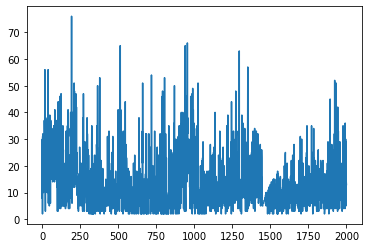

In [ ]:
train_dataset = ParserDataset(train_data, max_size=15000) # change max later
dev_dataset = ParserDataset(dev_data, max_size=15000)
plt.plot(dev_dataset.lens)
plt.show()

##Get subwords indicies
Output from the bert model contains split words that are unknown the model, this method gets ranges of indicies where the subswords start and end

In [ ]:
def get_word_level_indicies(tok_sentence):
    indices = []
    subword_start, pad = 0, 0
    for i in range(len(tok_sentence)):
        if tok_sentence[i].startswith("##") and not tok_sentence[i-1].startswith("##"):
            start = i-pad-1
            pad += 1
            indices.append(start)
        elif(tok_sentence[i].startswith("##") and tok_sentence[i-1].startswith("##")):
            pad += 1
            indices.append(start)
        else:
            indices.append(i-pad)
    return indices

In [ ]:
# example usage
tokens = ['oscar', 'is', 'always', 'late', 'ka', '##ffe', '##ts', '.', "hi", "my", "##name", "##rlfknlkrnelfkner", "jk"]
print(get_word_level_indicies(tokens))

##Batchifyer
Tokenizes the batches and converts them to tensors

In [ ]:
class BertBatcher():
    def __init__(self, device):
        self.device = device
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def __call__(self, batch):
        
        labels = [label for sentence, label in batch]
        sentences = [sentence for sentence, label in batch]

        word_level_indicies = []
        for sentence in sentences:
            sent_tokens = self.tokenizer.tokenize(sentence)
            sent_tokens = ["[CLS]"] + sent_tokens + ["[SEP]"] if len(sent_tokens) < 98 else ["[CLS]"] + sent_tokens[:98] + ["[SEP]"] # 98 = max length -2
            sent_tokens_padded = sent_tokens + (["[PAD]"] * (100 - len(sent_tokens))) if len(sent_tokens) < 100 else sent_tokens
            word_level_indicies.append(get_word_level_indicies(sent_tokens_padded))

        processed_sentence = self.tokenizer(sentences, padding="max_length", return_tensors="pt", max_length=100, truncation=True) #encode_plus sentence
        input_ids, attention_mask = itemgetter("input_ids", "attention_mask")(processed_sentence)

        return (input_ids.to(self.device), 
                attention_mask.to(self.device), 
                torch.stack(labels).to(self.device), 
                torch.tensor(word_level_indicies).to((self.device)))

In [ ]:
train_dataset = ParserDataset(train_data, max_size=10)
dev_dataset = ParserDataset(dev_data)

# test batcher and dataloader
bert_batcher = BertBatcher(device)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, collate_fn = bert_batcher)
test_dataloader = torch.utils.data.DataLoader(dev_dataset, batch_size=32, collate_fn = bert_batcher)

for i in train_dataloader:
    input_ids, attention_mask, labels, word_level_indicies = i
    break

##Customized BERT model
Added linear layers on top of the bert model to specilize it

In [ ]:
class CustomBERTModel(nn.Module):
    def __init__(self):
        super(CustomBERTModel, self).__init__()
        self.model = BertModel.from_pretrained("bert-base-uncased").to(device) ## move .to(device) outside class?
        self.weight = nn.Parameter(torch.empty(768, 768)).to(device)
        self.bias = nn.Parameter(torch.empty(100)).to(device)
        self.reset_parameters()

    def reset_parameters(self):
        bound = 1 / math.sqrt(self.weight.size(1))
        nn.init.uniform_(self.weight, -bound, bound)
        nn.init.uniform_(self.bias, -bound, bound)
    
    def forward(self, input_ids, attention_mask, word_level_indicies):

        model_out  = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = model_out[0]

        # apply word-level pooling
        pooled_last_hidden = scatter_mean(last_hidden_state, word_level_indicies, dim=1, dim_size=100)

        X = pooled_last_hidden[:, 1:pooled_last_hidden.shape[1], :]
        X_prime = pooled_last_hidden[ :, :pooled_last_hidden.shape[1], :]
        
        Y_arc = ((X @ self.weight) @ torch.transpose(X_prime, 1, -1)) + self.bias

        return Y_arc

In [ ]:
# test forward method
m = CustomBERTModel()
l = m.forward(input_ids, attention_mask, word_level_indicies).shape

##Training Loop
Trains the customized bert model

In [ ]:
def train(n_epochs=3, batch_size=16, lr=1e-5):
   
    train_dataset = ParserDataset(train_data, max_size=15000)
    dev_dataset = ParserDataset(dev_data, max_size=10000)

    bert_batcher = BertBatcher(device)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, collate_fn = bert_batcher)
    dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size, collate_fn = bert_batcher)

    custom_bert = CustomBERTModel()
    custom_bert.train()
    optimizer = torch.optim.AdamW(custom_bert.parameters(), lr = lr)

    # Make it possible to interrupt the training
    try:
        for epoch in range(n_epochs):
            with tqdm(total = len(train_loader)) as pbar:
                custom_bert.train()
                for input_ids, attention_mask, labels, word_level_indicies in train_loader:

                    optimizer.zero_grad()
                    output = custom_bert.forward(input_ids, attention_mask, word_level_indicies) 
                    
                    pad_indicies = torch.argmin(attention_mask, 1, keepdim=True)
                    weights = torch.zeros_like(output).to(device)
                    for i, row in enumerate(weights):
                        row[:pad_indicies[i][0], :pad_indicies[i][0]+1] = 1
                    
                    bce_loss = nn.BCEWithLogitsLoss(weight=weights)
                    loss = bce_loss(output, labels)

                    loss.backward(retain_graph=True)
                    optimizer.step()

                    pbar.set_postfix(loss = loss.item())
                    pbar.update(1)
                
                custom_bert.eval()

                accuracy, num_heads = 0, 0
                for input_ids, attention_mask, labels, word_level_indicies in dev_loader:

                    pad_indicies = torch.argmin(attention_mask, 1, keepdim=True)

                    with torch.no_grad():
                        output = custom_bert.forward(input_ids, attention_mask, word_level_indicies)

                    for i, sentence in enumerate(output):

                        predictions = torch.argmax(output[i], dim=1)
                        ys = torch.argmax(labels[i], dim=1)

                        predictions = predictions[1:pad_indicies[i][0].item()-1]
                        ys = ys[1:pad_indicies[i][0].item()-1]

                        accuracy += torch.sum(predictions == ys).item()
                        num_heads += predictions.shape[0]

                print("\nAccuracy",  accuracy/num_heads)
                        
    except KeyboardInterrupt:
        pass

    return custom_bert.model

In [ ]:
model = train(n_epochs=5, batch_size=32, lr=1e-5)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 392/392 [09:21<00:00,  1.43s/it, loss=0.00937]



Accuracy 0.10842329734772757


100%|██████████| 392/392 [09:21<00:00,  1.43s/it, loss=0.00863]



Accuracy 0.1451752632280421


100%|██████████| 392/392 [09:20<00:00,  1.43s/it, loss=0.00785]



Accuracy 0.18929095028655205


100%|██████████| 392/392 [09:20<00:00,  1.43s/it, loss=0.00671]



Accuracy 0.2782220445155271


100%|██████████| 392/392 [09:21<00:00,  1.43s/it, loss=0.0057]


Accuracy 0.36768625882980144


In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU

In [ ]:
# check gpu ram 
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
  print(gpu.name)
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Tesla P100-PCIE-16GB
Gen RAM Free: 12.5 GB  | Proc size: 95.2 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


##Evaluation
Evaluates the trained model

In [ ]:
def evaluate(model):
    metric = datasets.load_metric("accuracy")
    model.eval()

    for input_ids, attention_mask, labels in tqdm(test_dataloader, total=len(test_dataloader)):
        
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        metric.add_batch(predictions=predictions, references=labels)

    return metric.compute()